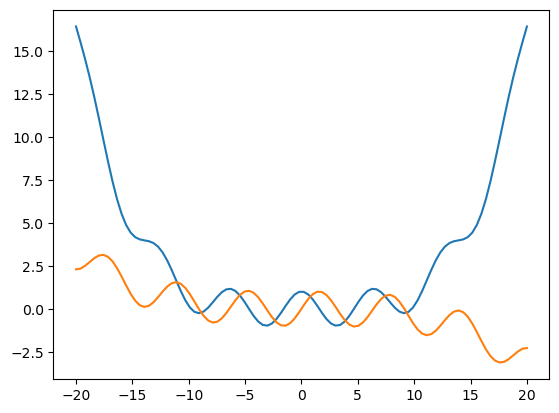

In [48]:
import propagators
import energy_landscapes
import long_simulation
import weighted_ensemble_2
import numpy as np
import MSM_methods
import analysis

import matplotlib.pyplot as plt
import importlib

importlib.reload(energy_landscapes)

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

kT = 1
dt = 0.001
nbins = 160
save_period = 100 #in steps; used to set nsteps below
system1 = energy_landscapes.unit_sine_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
#system1.analysis_bins(40)


simulation steps:
 Aggregate: 100000000 
 Molecular: 100000


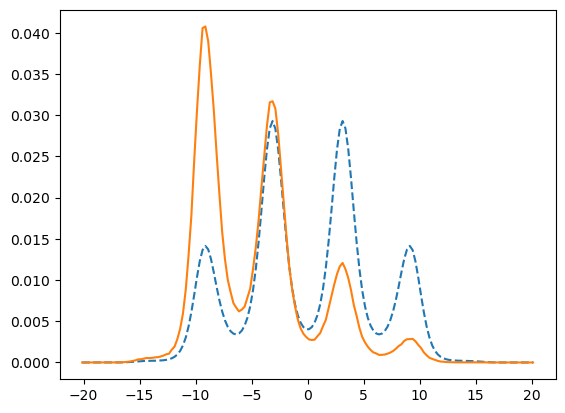

weighted MAE = 0.0008426259010806813
MFPT = 193509+-6197 steps
eigenvector converged to within 10^-12 after 6 rounds


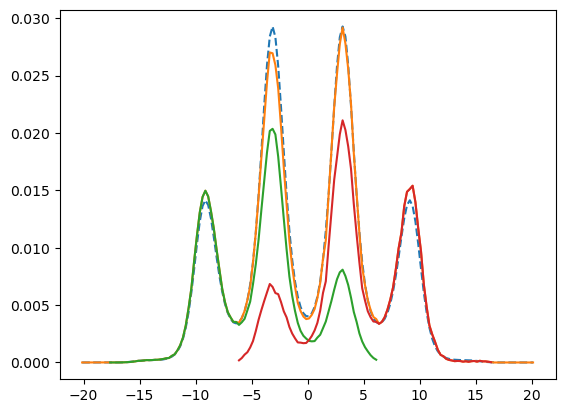

weighted MAE = 7.313468361477913e-05
MFPT = 77097+-963 steps


In [52]:
importlib.reload(MSM_methods)
importlib.reload(long_simulation)

x_init_coord = system1.standard_init_coord
nsteps = 100000
n_parallel = 1000
lag_time = 1

long_trjs = long_simulation.run_long_parallel_simulations(propagators.propagate, system1, kT, x_init_coord, dt, nsteps, save_period, n_parallel)
print(f"simulation steps:\n Aggregate: {nsteps*n_parallel} \n Molecular: {nsteps}")


#------------------------------------------------------------------------------------------
#non-MSM analysis
x, p = long_simulation.estimate_eq_pops_histogram(long_trjs, system1, nbins)
transitions, mfpts = long_simulation.calc_mfpt(system1.macro_class, system1.n_macrostates, save_period, long_trjs)
metrics = analysis.landscape_comparison(system1, kT, x, p, metrics = ["maew"])

analysis.print_mfpts_2states(mfpts)

#------------------------------------------------------------------------------------------
#MSM analysis
# x_msm, eqp_msm, mfpts_msm = long_simulation.msm_analysis(long_trjs, nbins, system1.macro_class, system1.n_macrostates(), save_period, lag_time=lag_time, show_TPM=False)
# metrics = analysis.landscape_comparison(system1, kT, x_msm, eqp_msm, metrics = ["maew"])

# analysis.print_mfpts_2states(mfpts_msm)


#TODO as a more stringent test break this into two cells: 
# In the first calculate MFPTs from a single long trajectory by brute force, 
# and in the second calculate them from many very short (too short to get accurate brute force results) ones with an MSM.
# if you build an MSM from trajectories so long the system has equilibrated by brute force you could get accurate MFPTs even if there's something wrong with MSM construction
#------------------------------------------------------------------------------------------
#haMSM analysis
#note that lag time is measured in saved frames
ha_transitions = long_simulation.get_ha_transitions(long_trjs, nbins, system1, lag_time=1)
x_hamsm, eqp_hamsm, x_ens, p_ens, mfpts_hamsm = analysis.hamsm_analysis(ha_transitions, nbins, system1, save_period, lag_time=1, show_TPM=False)
#long_simulation.hamsm_analysis(long_trjs, nbins, system1, save_period, lag_time=1, show_TPM=False)
metrics = analysis.landscape_comparison(system1, kT, x_hamsm, eqp_hamsm, metrics = ["maew"], ensemble_data = [x_ens, p_ens])

analysis.print_mfpts_2states(mfpts_hamsm)



# WE simulation

Each bin can hold up to 3 walkers, for a total of up to 486 walkers
[-20, 20]
0
400
800
1200
1600
2000
2400
2800
3200
3600
simulation steps:
 Aggregate: 21766300 
 Molecular: 400000


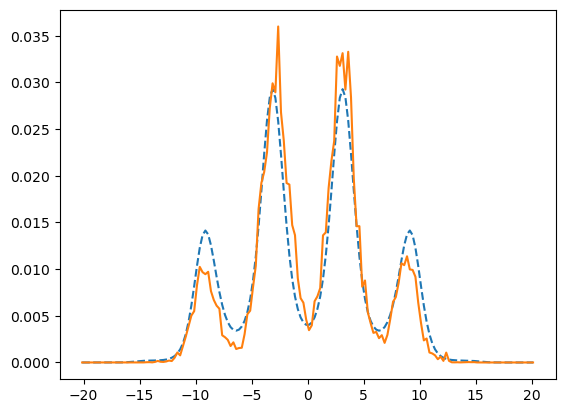

weighted MAE = 0.0002901624569058011
eigenvector converged to within 10^-12 after 38 rounds


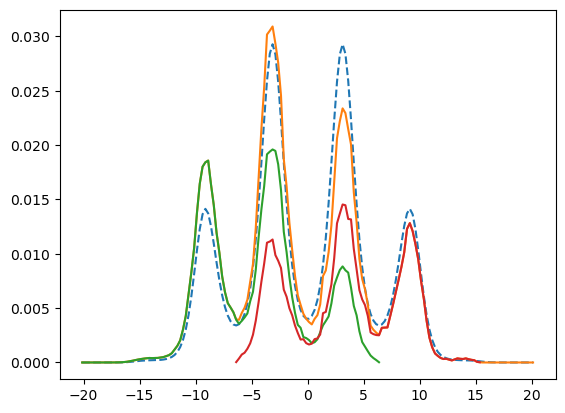

weighted MAE = 0.00025423852539622495
MFPT = 60779+-14366 steps


In [59]:
#Weighted ensemble (WE) parameters and inputs

N = 500             #total number of walkers within binrange
#nbins = 40         #total number of bins within binrange 
#nbins should match the value above, at least for analysis; make a separate n_bins_analysis variable

walkers_per_bin = round(N/nbins)
print(f"Each bin can hold up to {walkers_per_bin} walkers, for a total of up to {walkers_per_bin*(nbins+2)} walkers")

binrange = system1.standard_analysis_range 
print(binrange)

#progress coordinate range within which to bin simulations
                    #this should extend well past the stall point for examination of the WE stall force
                    #the area past either end of binrange is a bin extending to either + or - inf, yielding a total of nbins+2 bins
n_macrostates=2
        
nsteps = save_period        #round length; to match long simulations since MFPT = f(lag time)
nrounds = 4000              #number of WE rounds to run

x_init_val = system1.standard_init_coord

#run weighted ensemble with brownian dynamics
#put this on multiple lines
x_init, e_init, w_init, binbounds, xtrj, etrj, wtrj, transitions, hamsm_transitions, n_trans_by_round \
= weighted_ensemble_2.weighted_ensemble_start(\
                    x_init_val,\
                    nrounds,\
                    nbins,\
                    walkers_per_bin,\
                    binrange, propagators.propagate_save1,\
                    [system1, kT, dt, nsteps],\
                    system1.ensemble_class,\
                    n_macrostates,\
                    ha_binning=False)


aggregate_walkers = len([j for i in xtrj for j in i])
print(f"simulation steps:\n Aggregate: {nsteps*aggregate_walkers} \n Molecular: {nsteps*nrounds}")

x, p, xs, es = weighted_ensemble_2.landscape_recovery(xtrj, wtrj, binbounds, transitions, hamsm_transitions, n_trans_by_round, nrounds, n_macrostates, system1.potential, system1.macro_class, kT)
metrics = analysis.landscape_comparison(system1, kT, x, p, metrics = ["maew"])

x_hamsm, eqp_hamsm, x_ens, p_ens, mfpts_hamsm = analysis.hamsm_analysis(hamsm_transitions, nbins, system1, nsteps, lag_time=1, show_TPM=False)
#long_simulation.hamsm_analysis(long_trjs, nbins, system1, save_period, lag_time=1, show_TPM=False)
metrics = analysis.landscape_comparison(system1, kT, x_hamsm, eqp_hamsm, metrics = ["maew"], ensemble_data = [x_ens, p_ens])
analysis.print_mfpts_2states(mfpts_hamsm)


In [ ]:
#IDEA: can populate bins by resuming previously-terminated walkers, especially deeply-branching ones; could include these 'ghost' walkers in RMSD comparisons as well